## Exporting and Text Parsing of Drillhole Data
This notebook reads in from an export of the PostGIS/PostgreSQL WAMEX (Western Australian Mineral) database. An export is used in this workshop, instead of directly connecting to the database, for demostration purposes. WAMEX contains mineral exploration reports and data that have lapsed the period of confidentiality. Online access is free of charge at:
https://www.dmp.wa.gov.au/Geological-Survey/Mineral-exploration-Reports-1401.aspx

From this database export, we pullout the following information: <br>
1 ) Collar (CollarID, Longitude, Latitude, RL, MaxDepth) <br>
2 ) Survey (CollarID, Depth, Azimuth, Dip) <br>
3 ) Lithology (CollarID, From_Depth, To_Depth, Company_LithoCode) <br>

The Survey table is further processed to calculate downhole X,Y,Z using minimum curvature.
The Lithology table is further processed to decode the Company Codes into their respective lithologies. These lithologies are then standardized across different drilling campaigns and upscaled to be classified into broader rock types.

## WAMEX Database
Let's take a look at what the database information looks like and how these tables are related:
<a href="./graphics/gswadh_schema.pdf">gswadh_schema.pdf</a>
<img src='./graphics/gswadh_schema.bmp'>
<br>
Today, we will focus on tables necessary for collar, survey and lithology files.
<img src='./graphics/postgres-database.png'>

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from dh2loop import dh2l
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

IndentationError: unindent does not match any outer indentation level (dh2l.py, line 76)

In [1]:
%run -i "dh2l_config.py"

Default parameters loaded from dh2l_config.py:
#Database Files
data_path='../data/'
wamex_path='../data/wamex/'
collar_file=wamex_path+'collar.csv'
collarattr_file=wamex_path+'collarattr.csv'
dhsurvey_file=wamex_path+'dhsurvey.csv'
dhsurveyattr_file=wamex_path+'dhsurveyattr.csv'
dhgeology_file=wamex_path+'dhgeology.csv'
dhgeologyattr_file=wamex_path+'dhgeologyattr.csv'

#Thesauri
rl_maxdepth_dic_file= wamex_path+'rl_maxdepth_dic.csv'
survey_dic_file=wamex_path+'survey_dic.csv'
dic_attr_val_lithology_filter_file=wamex_path+'dic_attr_val_lithology_filter.csv'
litho_dic_1_file=wamex_path+'litho_dic_1,csv'
cleanup_lithology_file=wamex_path+'cleanup_lithology.csv'
dic_att_col_lithology_file=wamex_path+'dic_att_col_lithology.csv'
CET_hierarchy_dico_file=wamex_path+'hierarchy_dico.csv'

#ExportFiles
export_path='../data/export/'
DB_Collar_Export=export_path+'DB_Collar_Export.csv'
DB_Survey_Export=export_path+'DB_Survey_Export.csv'
CET_Litho=export_path+'CET_Litho.csv'
DB_Lithology_Export=expo

## Exporting Collar Data

Let's take a look at collar and collarattr table:

In [5]:
collar= pd.read_csv(collar_file,encoding = "ISO-8859-1", dtype='object')
collar.head()

,id,holeid,anumber,companyholeid,dataset,companyid,longitude,latitude,istransformed,modifieddate,modifiedby,mrtfileid,holetype,maxdepth,geom
0,153802,69189Minjar NorthSSRC007,69189,SSRC007,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,127,0101000020E610000000000000C33C5D4000000000E0E7...
1,153803,69189Minjar NorthSSRC008,69189,SSRC008,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,130,0101000020E6100000000000C0C23C5D4000000020E0E7...
2,153804,69189Minjar NorthSSRC009,69189,SSRC009,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,120,0101000020E610000000000000C23C5D4000000040E0E7...
3,153813,69189Minjar NorthSSRC019,69189,SSRC019,Minjar North,3049,116.949,-28.9065,True,NaN,NaN,5252,RC,174,0101000020E610000000000040C03C5D40000000E00FE8...
4,153815,69189Minjar NorthSSRC021,69189,SSRC021,Minjar North,3049,116.949,-28.9068,True,NaN,NaN,5252,RC,156,0101000020E6100000000000E0C33C5D400000000027E8...


In [6]:
collarattr= pd.read_csv(collarattr_file,encoding = "ISO-8859-1", dtype='object')
collarattr.loc[collarattr['collarid'] == '153802']

NameError: name 'collarattr_file' is not defined

We can see that for drillhole# 153802: <br>
RL = Elevation = 359.251 <br>
MaxDepth = TD =127<br>

Now, let's look at another hole (# 792833):

In [5]:
collarattr.loc[collarattr['collarid'] == '792833']

,id,collarid,attributecolumn,attributevalue,modifieddate,modifiedby,mrtdetailid
623,9596789,792833,RL,407.302,NaN,NaN,511733
624,9596790,792833,Depth (m),630.20,NaN,NaN,511734
625,9596791,792833,MGA Azimuth,139.80,NaN,NaN,511735
626,9596792,792833,Dip,-60.11,NaN,NaN,511736
627,9596793,792833,Drill Type,DD,NaN,NaN,511737
628,9596794,792833,Grid,"""GDA94, MGA50""",NaN,NaN,511738
629,9596795,792833,Drilling Company,"""Mt. Magnet Drilling, Wangara, Perth""",NaN,NaN,511739
630,9596796,792833,Date Completed,20/01/06,NaN,NaN,511740


We can observe that this time: <br>
RL = RL = 620.20 <br>
MaxDepth = Depth (m) =630.20<br>    

In order to pullout the corresponding RL and MaxDepth values for each drillhole, it was necessary to build a thesaurus.
Here is a quick look into the RL and MaxDepth thesuarus:

In [6]:
rl_maxdepth_dic= pd.read_csv(rl_maxdepth_dic_file,encoding = "ISO-8859-1", dtype='object')
rl_maxdepth_dic.loc[rl_maxdepth_dic['cet_attributecolumn'] == 'rl']

,attributecolumn,cet_attributecolumn
111,"""""""RL""""""",rl
112,"""Nominal\nRL """,rl
113,"""RLLocal""",rl
114,"""RLOrig""",rl
115,"""RLSurvMethod""",rl
116,325RL,rl
117,ACC_RL,rl
118,ADJ_RL,rl
119,Adjusted_RL,rl
120,AGD84_RL,rl


In [7]:
rl_maxdepth_dic.loc[rl_maxdepth_dic['cet_attributecolumn'] == 'maxdepth']

,attributecolumn,cet_attributecolumn
0,TD,maxdepth
1,Total depth,maxdepth
2,"""""""DEPTH""""""",maxdepth
3,"""""""TOT_DEPTH""""""",maxdepth
4,"""Final\nDepth(m)""",maxdepth
5,"""Hole\nDepth""",maxdepth
6,"""Max Depth\n metres""",maxdepth
7,"""Max Depth\n""",maxdepth
8,AC Depth,maxdepth
9,Actual Depth,maxdepth


Using the thesaurus and a little bit of code and cleaning up, we can extract the collar information.

In [8]:
dh2l.collar_attr_col_dic(rl_maxdepth_dic_file)
dh2l.collar_collarattr_final(collar, collarattr, rl_maxdepth_dic_file, DB_Collar_Export)

NameError: name 'colar_ele' is not defined

This outputs a collar file in the export folder. Let's take a look at the export.

In [8]:
DB_Collar_Export=pd.read_csv(DB_Collar_Export,encoding = "ISO-8859-1", dtype='object')
print(DB_Collar_Export)

    CollarID                     HoleId Longitude  Latitude       RL MaxDepth  \
0    1146526   71288Minjar NorthSSDD006   116.948  -28.8991  356.255    546.4   
1    1146528   71288Minjar NorthSSDD008   116.947  -28.9021  356.871    405.0   
2    1146530   71288Minjar NorthSSDD010   116.949  -28.9083  360.214    249.0   
3    1146531   71288Minjar NorthSSDD011   116.948  -28.9002  357.153    468.0   
4    1146650   71288Minjar NorthSSDD005   116.948  -28.9002  357.156      150   
5    1233095         82655KararaBHN1001   116.818  -29.1504  383.557      108   
6    1233096         82655KararaBHN1002   116.818   -29.151  382.505      108   
7    1233098         82655KararaKAR1001   116.775  -29.1886  414.225    713.4   
8    1233099         82655KararaKAR1002   116.775  -29.1885  414.093    620.2   
9    1233100         82655KararaKAR1003   116.774  -29.1913  439.337      200   
10   1233101         82655KararaKAR1004   116.775  -29.1913  439.583      186   
11   1233102         82655Ka

In [9]:
plot_collar (DB_Collar_Export, geology)

AttributeError: module 'geopandas' has no attribute 'points_from_xy'

## Exporting Survey Data

 The same approach is done for survey data.

In [10]:
dhsurvey= pd.read_csv(dhsurvey,encoding = "ISO-8859-1", dtype='object')
dhsurvey.loc[dhsurvey['id'] == '1841119']

,id,collarid,depth,units,accuracy,loaddate,loadby,modifieddate,modifiedby,mrtfileid,dip,azimuth
1420,1841119,792866,50,NaN,NaN,2011-11-23 10:00:39.48,MIMEISS,NaN,NaN,22456,NaN,NaN


In [11]:
dhsurveyattr= pd.read_csv(dhsurveyattr,encoding = "ISO-8859-1", dtype='object')
dhsurveyattr.loc[dhsurveyattr['dhsurveyid'] == '1841119']

,id,dhsurveyid,attributecolumn,attributevalue,loaddate,loadby,modifieddate,modifiedby,mrtdetailid
0,10893657,1841119,Grid,"""GDA94, MGA50""",2011-11-23 10:00:39.48,MIMEISS,NaN,NaN,511746
1,10893656,1841119,Survey Method,Gyrohum,2011-11-23 10:00:39.48,MIMEISS,NaN,NaN,511745
2,10893655,1841119,Azimuth,315.95,2011-11-23 10:00:39.48,MIMEISS,NaN,NaN,511744
3,10893654,1841119,Dip,-62.07,2011-11-23 10:00:39.48,MIMEISS,NaN,NaN,511743


This time we use a thesaurus to identify Azimuth and Dip readings.

In [12]:
survey_dic= pd.read_csv(survey_dic,encoding = "ISO-8859-1", dtype='object')
survey_dic.loc[survey_dic['new_name'] == 'AZI']

,attr_col,new_name
0,Aximuth,AZI
1,AZ,AZI
2,AZ_COMET,AZI
3,AZ_Eelya,AZI
4,AZ_MGX_LOC,AZI
5,AZ_Webbs,AZI
6,AZIM,AZI
7,Azim,AZI
8,AZIMUTH,AZI
9,Azimuth,AZI


In [13]:
survey_dic.loc[survey_dic['new_name'] == 'DIP']

,attr_col,new_name
142,Dip,DIP
143,DIP,DIP
144,dip,DIP
145,Dip (deg.),DIP
146,Dip_2,DIP
147,INC,DIP
148,Inclination,DIP
149,DIP (deg.),DIP


In [14]:
dh2l.survey_attr_col_dic(survey_dic)
dh2l.survey_final(dhsurvey,dhsurveyattr, DB_Survey_Export)

## Exporting Lithology Data

In [15]:
dh2l.litho_attr_val_dic (dic_attr_val_lithology_filter)
dh2l.litho_dico(litho_dic_1)
dh2l.clean_up(cleanup_lithology)
dh2l.litho_attr_val_with_fuzzy(CET_Litho)
dh2l.litho_final(dhgeology, dhgeologyattr, DB_Lithology_Export)

NameError: name 'collar' is not defined

Exporting lithology is a bit more tricky than collar and survey because what we get are rock codes (i.e., BAS, GRA) that have to be further decoded.
Let's breakdown the steps done in the export.

<img src='./graphics/lithology_thesauri.png'>

First, the Company_LithoCodes are pulled out the same way we did for Collar and Survey. We use a thesaurus that lists all the attribute columns that refer to lithology.

The second thesaurus decodes the Company_Litho for the corresponding Company_LithoCode.

In [230]:
dic_att_col_lithology=pd.read_csv(dic_att_col_lithology,encoding = "ISO-8859-1", dtype='object')
print(dic_att_col_lithology)

   attributecolumn
0     lithological
1     lihological 
2              LIT
3             LITH
4             Lith
..             ...
43           rock1
44        ROCKCODE
45        Rockcode
46       RockMajor
47       wmc_lith1

[48 rows x 1 columns]


Before performing the fuzzywuzzy matching, the Company_Litho text is cleaned to remove extra symbols and descriptions. This includes mineral names, ages and qualifiers (i.e, dominant, abundant, minor).

In [231]:
cleanup_lithology=pd.read_csv(cleanup_lithology,encoding = "ISO-8859-1", dtype='object')
print(cleanup_lithology)

               clean
0            uranium
1           abundant
2         actinolite
3         adcumulate
4           adjacent
..               ...
545           zircon
546          zoisite
547  undiferentiated
548   differentiated
549           undiff

[550 rows x 1 columns]


We use the fuzzywuzzy algorithm to standardize the lithologies. The fuzzywuzzy matching compares the Company_Litho phrase against a master thesaurus. FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. It uses the Levenshtein Distance to calculate the differences between sequences.

The processor we used to do the matching is: fuzz.token_set_ratio. It tokenize strings, but split the tokens into groups: intersection and remainder before comparing. It is not as strict as a using an exact processor but stricter than a partial match. Having a comprehensive thesaurus allows us this processor to work effectively. For more information on this: https://www.geeksforgeeks.org/fuzzywuzzy-python-library/

Here's the pseudocode:<br>
&emsp; scores=process.extract(Cleaned_Company_Litho, Litho_Dico, scorer=fuzz.token_set_ratio)<br>
&emsp; &emsp; for sc in scores:                     
&emsp; &emsp; &emsp; if(sc[score]>bestmatch): #better than previous best match<br>
&emsp; &emsp; &emsp; &emsp; bestmatch =  sc[score]<br>
&emsp; &emsp; &emsp; &emsp; bestlitho= Litho_Dico[firstword]<br>
&emsp; &emsp; &emsp; &emsp; if(sc[litho]==Cleaned_Company_Litho[last]): #bonus for being last word in phrase<br>
&emsp; &emsp; &emsp; &emsp; bestmatch=bestmatch*1.01<br>
&emsp; &emsp; &emsp; elif (sc[score]==bestmatch): #equal to previous best match<br>
&emsp; &emsp; &emsp; &emsp; if(sc[0]==words[last]): #bonus for being last word in phrase<br>
&emsp; &emsp; &emsp; &emsp; &emsp; bestlitho=Litho_Dico[firstword]<br>
&emsp; &emsp; &emsp; &emsp; &emsp; bestmatch=bestmatch*1.01<br>
<br>
The pseudocode shows that we input the Cleaned_Company_Litho and we parse it through a lithology thesaurus. We take in the score for each iteration and if it is greater than the previous match, it store the score and the first lithology listed in the corresponding lithology thesaurus entry. A bonus is also added to the score if the Cleaned_Company_Litho's last word matches the thesaurus.
<br>
Furthermore, if the match is less than a threshold we set (in this case, 80). The CET_Litho is classified as "Other".

Let's take a look at the Lithology Thesaurus. Each row refers to one entry. Each synonym is separated by a space.

In [247]:
lithology_thesaurus=pd.read_csv(litho_dic_1,encoding = "ISO-8859-1", dtype='object')
print(lithology_thesaurus)

                                                 clean
0                    Aeolian_deposit  Aeolian_Deposits
1                                            Aeolinite
2    Blown_sand Beach_dune_sand Coversand Niveo-aeo...
3                                                 Dune
4               Fluvioaeolian_Silt Fluvio-Aeolian_Silt
..                                                 ...
752                                Comenditic Trachyte
753                                           Aphanite
754                                           Porphyry
755                    Intermediate Intermediate_Rocks
756                             Mafic Mafic_Rock Basic

[757 rows x 1 columns]


Let's take a look at the results:

In [290]:
DB_Lithology_Export=pd.read_csv(DB_Lithology_Export_Backup,encoding = "ISO-8859-1", dtype='object')
print(DB_Lithology_Export)

      Company_ID CollarID FromDepth ToDepth Company_LithoCode  \
0            872   831903       102  103.29               Avn   
1            872   831903       113  114.86               Avn   
2            872   831902        94   95.02               Avn   
3            872   831902        71   74.01               Avn   
4            872   831903       115  118.85               Avn   
...          ...      ...       ...     ...               ...   
19540       3050  1146526        45      46                 X   
19541       3050  1146650        59      60                 V   
19542       3050  1146650        53      54                Ac   
19543       3050  1146526        46      48                 X   
19544       3050  1146526        46      48                 X   

                Company_Litho          CET_Litho Score  
0         Quartz Apalite Vein               vein   101  
1         Quartz Apalite Vein               vein   101  
2         Quartz Apalite Vein               vein

## Upscaling Lithology Data

In [311]:
CET_hierarchy_dico = pd.read_csv(CET_hierarchy_dico,encoding = "ISO-8859-1")

In [319]:
upscale_litho(DB_Lithology_Export, CET_hierarchy_dico, DH_Lithology_Upscaled)
Upscaled_Litho= pd.read_csv(DH_Lithology_Upscaled,encoding = "ISO-8859-1")
Upscaled_Litho.head()

,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,Score,Level 2,Level 1,CET_Litho
0,1286,1932295,152,154.4,SIF,Banded iron-formation,71,unclassified rock,unclassified_rock,Other
1,1286,1932295,150,152.1,SIF,Banded iron-formation,71,unclassified rock,unclassified_rock,Other
2,1286,1932295,132,150.7,SIF,Banded iron-formation,71,unclassified rock,unclassified_rock,Other
3,1286,1932292,92,94,S,Sedimentary rocks-undivided,70,unclassified rock,unclassified_rock,Other
4,1286,1932295,195,201.25,SIF,Banded iron-formation,71,unclassified rock,unclassified_rock,Other


In [320]:
Upscaled_Litho[Upscaled_Litho['Level 1'] == "igneous"]

,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,Score,Level 2,Level 1,CET_Litho
10473,1286,1547546,36,37,MBA,Basalt,101,mafic_fine-grained crystalline,igneous,basalt
10474,1286,4114932,90,100,MBA,Basalt,101,mafic_fine-grained crystalline,igneous,basalt
10475,1621,1233224,347,350.95,Mb,basalt,101,mafic_fine-grained crystalline,igneous,basalt
10476,2708,1898720,107,119,METB,Metabasalt,101,mafic_fine-grained crystalline,igneous,basalt
10477,2708,1898735,73,101,BLT,Basalt,101,mafic_fine-grained crystalline,igneous,basalt
...,...,...,...,...,...,...,...,...,...,...
19183,3050,792807,40,53,U,ultramafic rocks,97,ultramafic,igneous,ultramafic-rock
19184,3050,792807,26,31,U,ultramafic rocks,97,ultramafic,igneous,ultramafic-rock
19185,3050,792807,35,36,U,ultramafic rocks,97,ultramafic,igneous,ultramafic-rock
19186,3050,548917,200,204,U,ultramafic rocks,97,ultramafic,igneous,ultramafic-rock


In [321]:
Upscaled_Litho[Upscaled_Litho['Level 2'] == "ore"]

,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,Score,Level 2,Level 1,CET_Litho
14678,1621,1233261,95,108,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14679,1621,1233231,120,121.9,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14680,1621,1233223,375,377.08,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14681,1621,1233301,35,38,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14682,1621,1233130,21,23,S,massive sulphides,91,ore,mineralisation,massive_sulphide
...,...,...,...,...,...,...,...,...,...,...
14836,3050,792847,4,8,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14837,3050,792836,8,9,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14838,3050,792935,11,12,S,massive sulphides,91,ore,mineralisation,massive_sulphide
14839,3050,792836,18,19,S,massive sulphides,91,ore,mineralisation,massive_sulphide


In [323]:
import pygslib

ModuleNotFoundError: No module named 'ezdxf'

In [326]:
collar = pd.read_csv(DB_Collar_Export,encoding = "ISO-8859-1", dtype='object')
survey = pd.read_csv(DB_Survey_Export,encoding = "ISO-8859-1", dtype='object')
lithology = pd.read_csv(DB_Lithology_Upscaled,encoding = "ISO-8859-1", dtype='object')
print (collar.dtypes)

CollarID      object
HoleId        object
Longitude     object
Latitude      object
RL            object
MaxDepth      object
Unnamed: 6    object
dtype: object


NameError: name 'x' is not defined

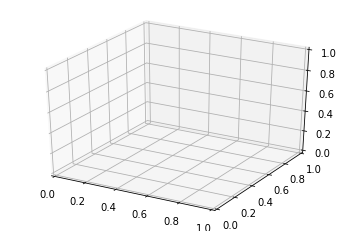

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
# several data points 
r = np.array([0, 14, 64, 114])
# get lengths of the separate segments 
r[1:] = r[1:] - r[:-1]
phi = np.array([255.6, 255.6, 261.7, 267.4])
theta = np.array([-79.5, -79.5, -79.4, -78.8])
ax.plot(np.cumsum(x),np.cumsum(y),np.cumsum(z))

# convert to radians
#phi = phi * 2 * np.pi / 360.
# in spherical coordinates theta is measured from zenith down; you are measuring it from horizontal plane up 
#theta = (90. - theta) * 2 * np.pi / 360.
# get x, y, z from known formulae
#x = r*np.cos(phi)*np.sin(theta)
#y = r*np.sin(phi)*np.sin(theta)
#z = r*np.cos(theta)
# np.cumsum is employed to gradually sum resultant vectors 
#ax.plot(np.cumsum(x),np.cumsum(y),np.cumsum(z))
#https://stackoverflow.com/questions/20687164/convert-a-3d-drillhole-trace-to-cartesian-coordinates-and-plot-it-with-matplotlib